In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from analyzer.metric import MetricCalculator
from analyzer.model.classification_model import ClassificationModel
from data import Reader, Saver
from plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from encoder import Encoder
from preparation import DataPreparation, Normalizer
from analyzer.model import KNNHandMade

## Исходные данные

In [174]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv('https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_KNN_IncomeMoney.csv')
df = df_original.copy().reset_index(drop=True)
df = Reader.replace_symbol_in_data(df, '?')
df.head(10)

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,47,Self-emp-not-inc,190072,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Iran,>50K
1,37,Self-emp-inc,30529,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,2415,50,United-States,>50K
2,45,Federal-gov,179638,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,>50K
3,61,Private,129246,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,48,United-States,<=50K
4,30,Private,196396,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
5,20,other,168863,Some-college,10,Never-married,other,Own-child,White,Female,0,0,20,United-States,<=50K
6,46,Private,59767,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,50,United-States,<=50K
7,41,Private,166662,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
8,36,other,36635,Some-college,10,Never-married,other,Unmarried,White,Female,0,0,25,United-States,<=50K
9,39,Local-gov,187385,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,28,United-States,>50K


fnlwgt (final weight) – примерная оценка количества людей, которое представляет каждая строка данных

educational-num – длительность обучения

capital gain - это экономическая концепция, определяемая как прибыль, полученная от продажи актива, стоимость которого увеличилась за период владения.

capital loss — это убыток, который возникает, когда стоимость капитальных активов, таких как инвестиции или недвижимость, снижается.

# Постановка задачи
1. Определить какие признаки более всего влияют на таргет, 
2. построить модель наивного Байеса когда все колонки переведны в вид категорий, 
3. построить модель логистической регрессии с L1 регуляризацией, чтобы выявить какие признаки "мусорные", 
4. после лекции в понедельник построить дерево решений и модель svm.

# Оптимизируем данные

In [175]:
# посмотрим на пропуски в данных
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

In [176]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [177]:
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [178]:
# Оптимизируем память
df['age'] = df['age'].astype('uint8')
df['fnlwgt'] = df['fnlwgt'].astype('int32')
df['educational_num'] = df['educational_num'].astype('uint8')
df['capital_gain'] = df['capital_gain'].astype('uint32')
df['capital_loss'] = df['capital_loss'].astype('uint16')
df['hours_per_week'] = df['hours_per_week'].astype('uint8')

# Убеждаемся в изменениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  uint8 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int32 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  uint8 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  uint32
 11  capital_loss     48842 non-null  uint16
 12  hours_per_week   48842 non-null  uint8 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int32(1), object(9), uint16(1), uint32(1), uint8(3)
memory usage: 4.0+ MB


In [179]:
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


# Проводим первичный визуальный анализ

In [180]:
# Посмотрим описательную статистику непрерывных величин
df.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


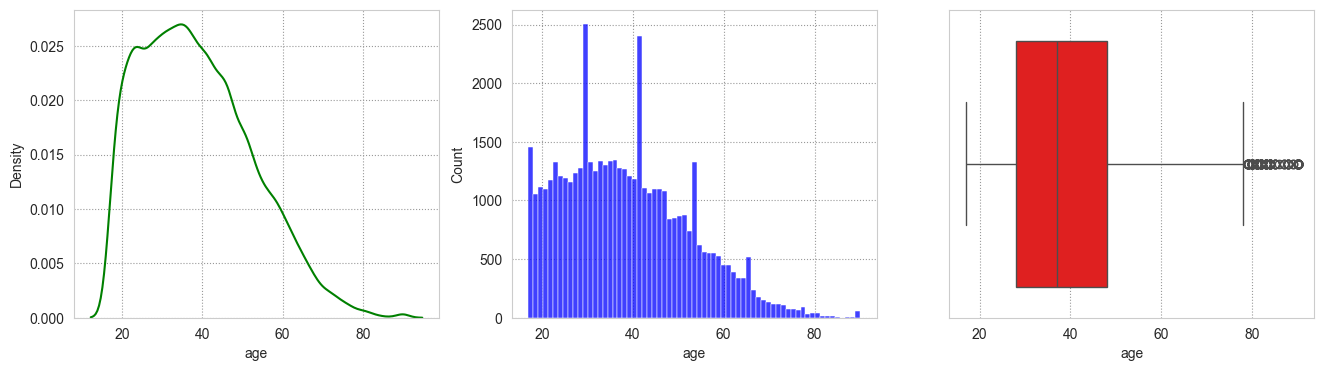

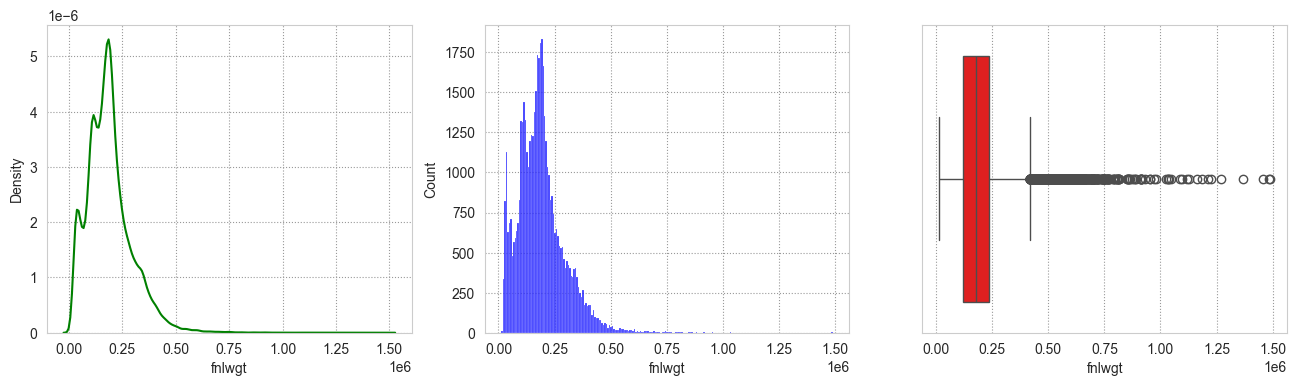

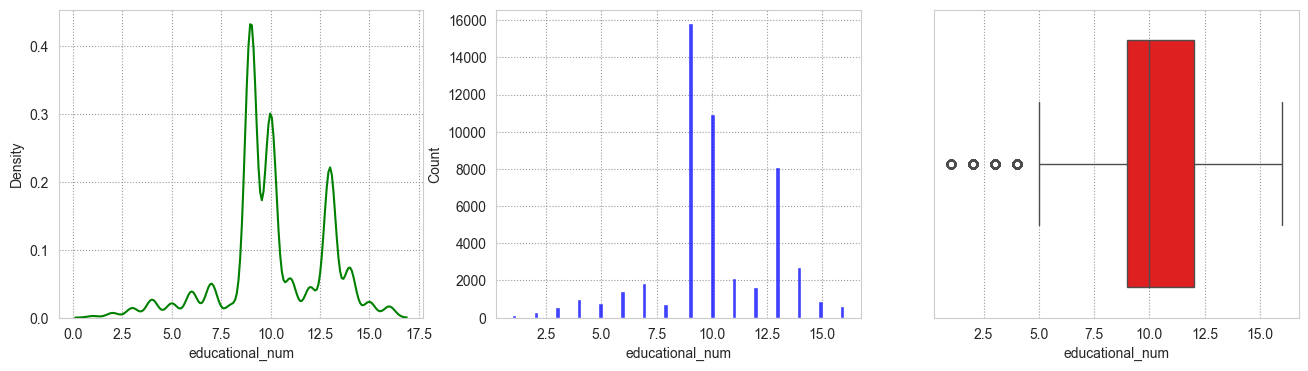

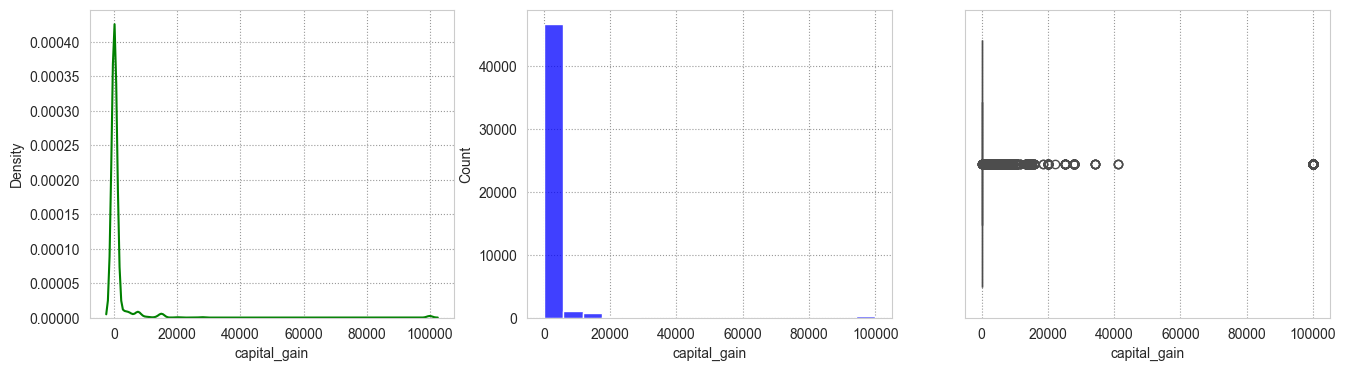

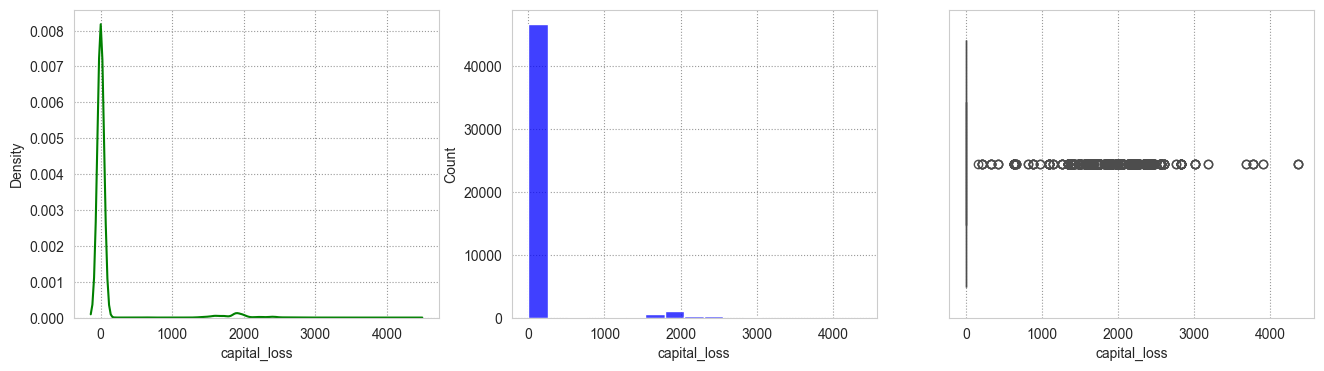

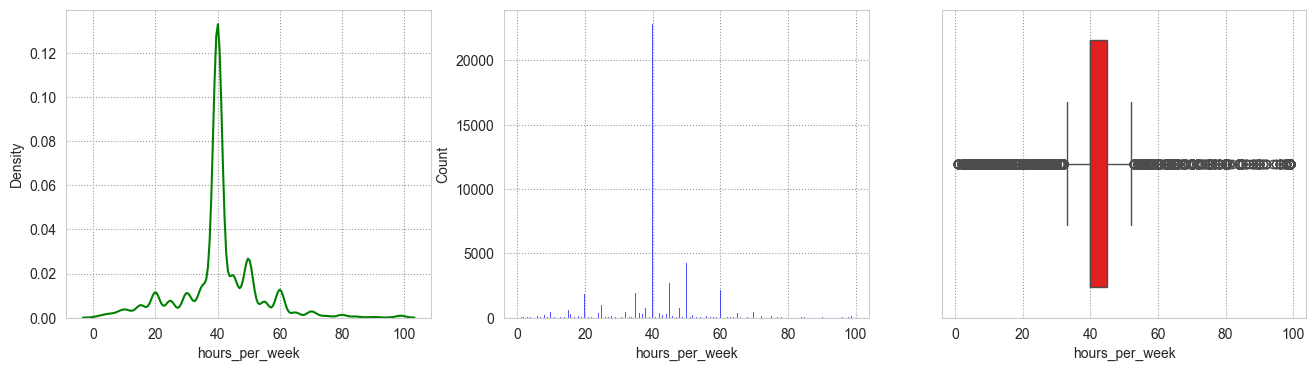

In [181]:
# Посмотрим на распределение непрерывных величин
Drawer.plot_numeric_seaborn(df)
# Drawer.plot_numeric_plotly(df)

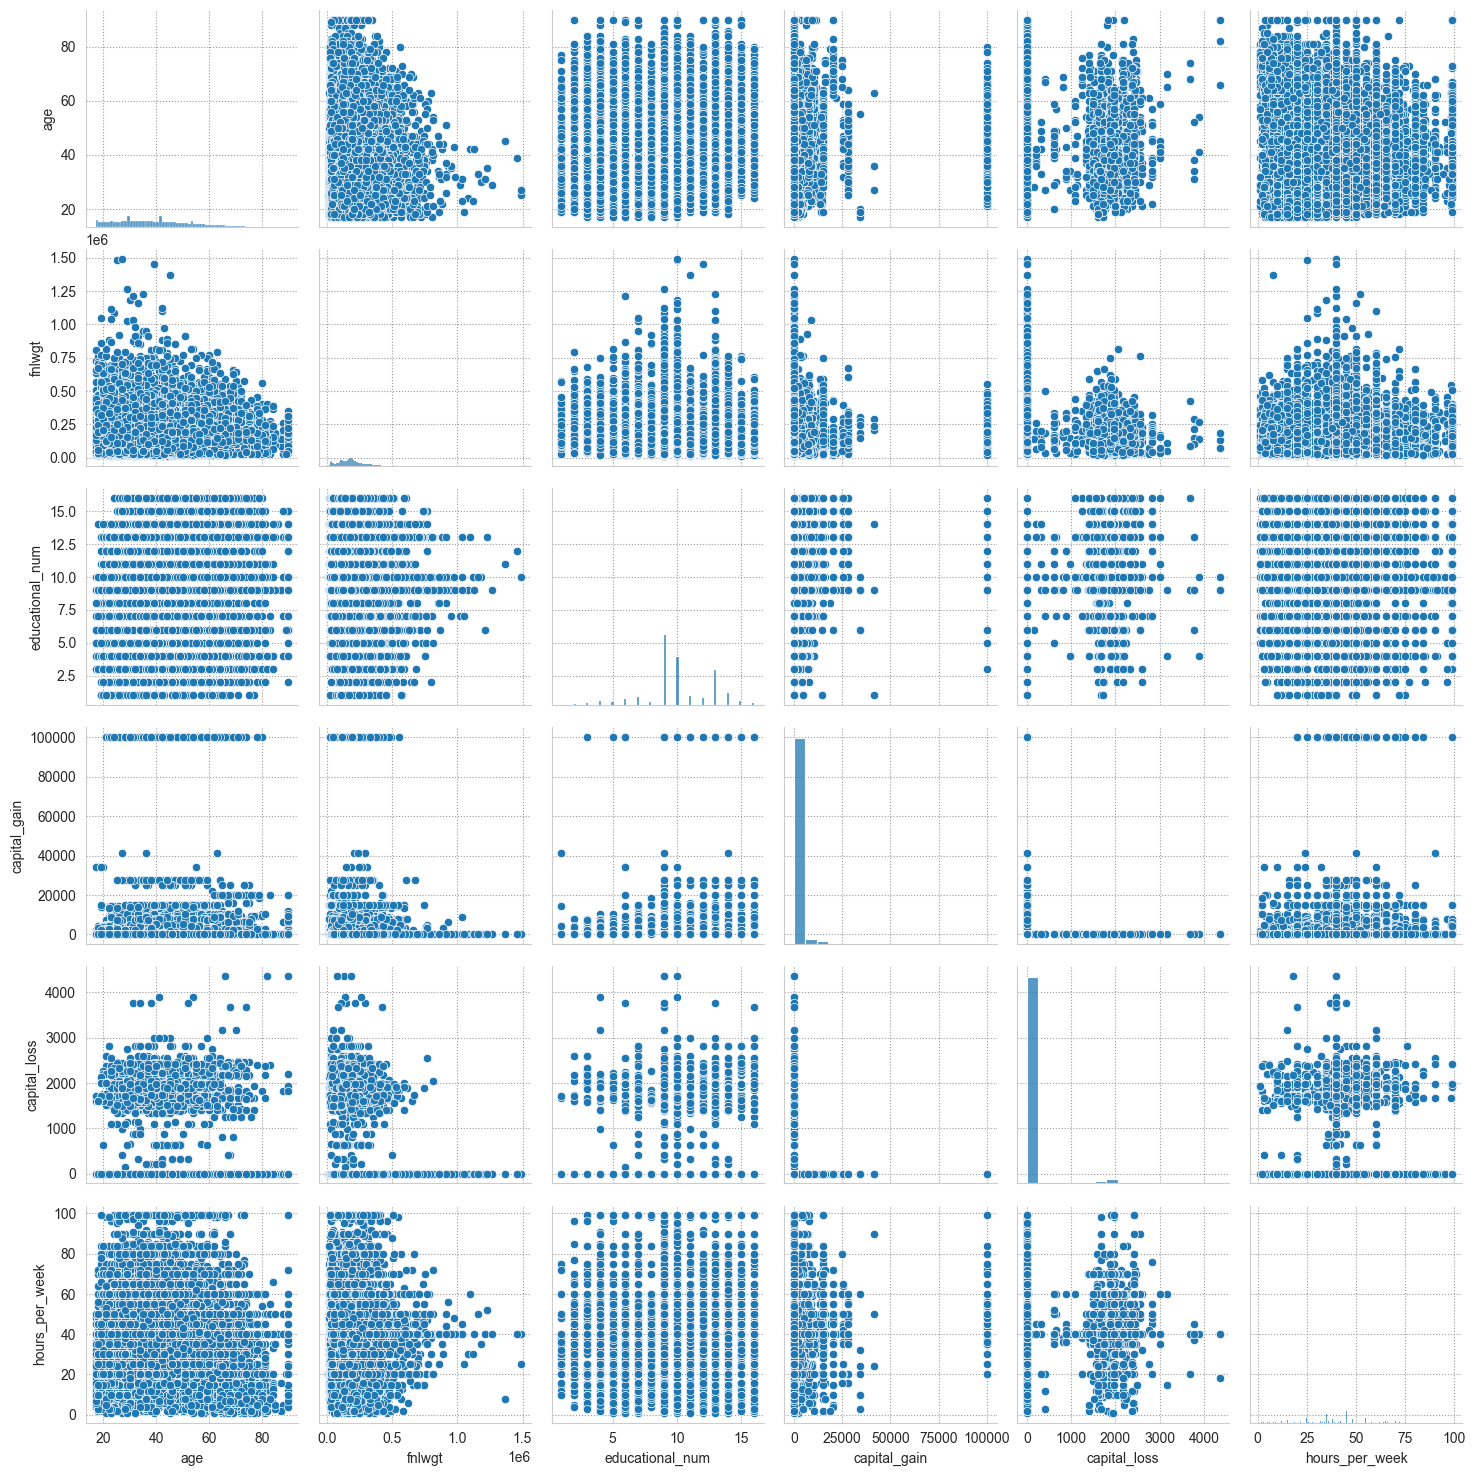

In [182]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

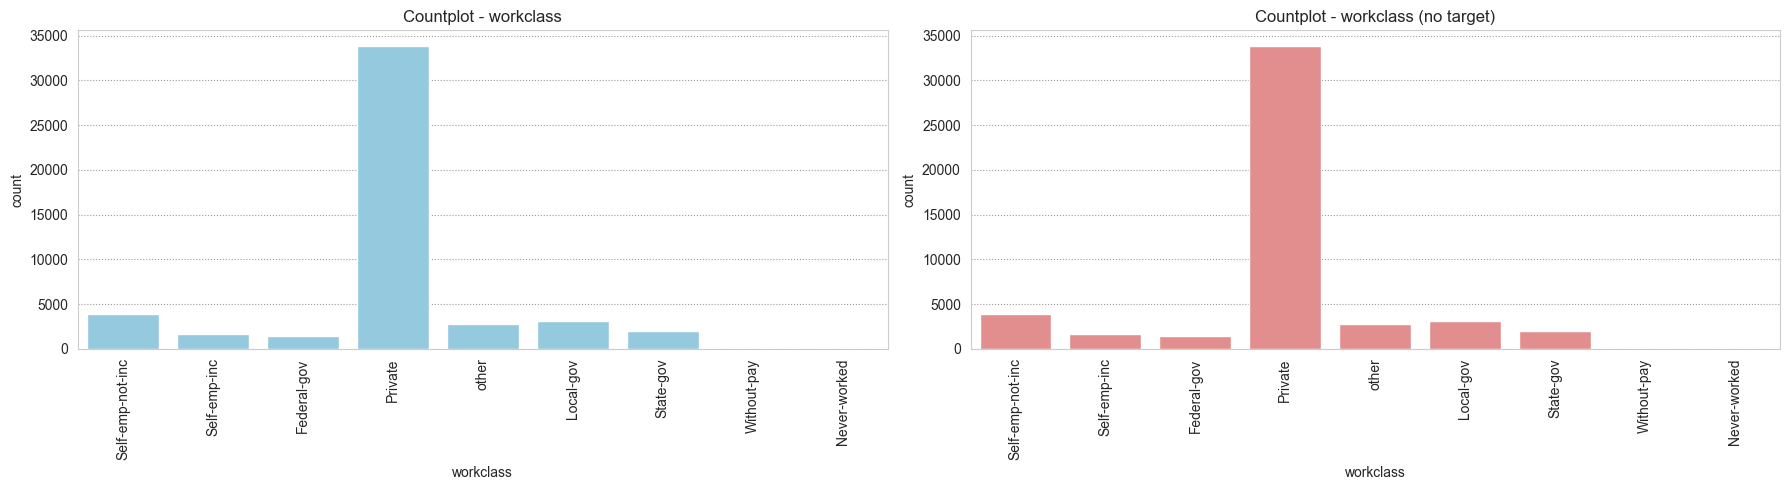

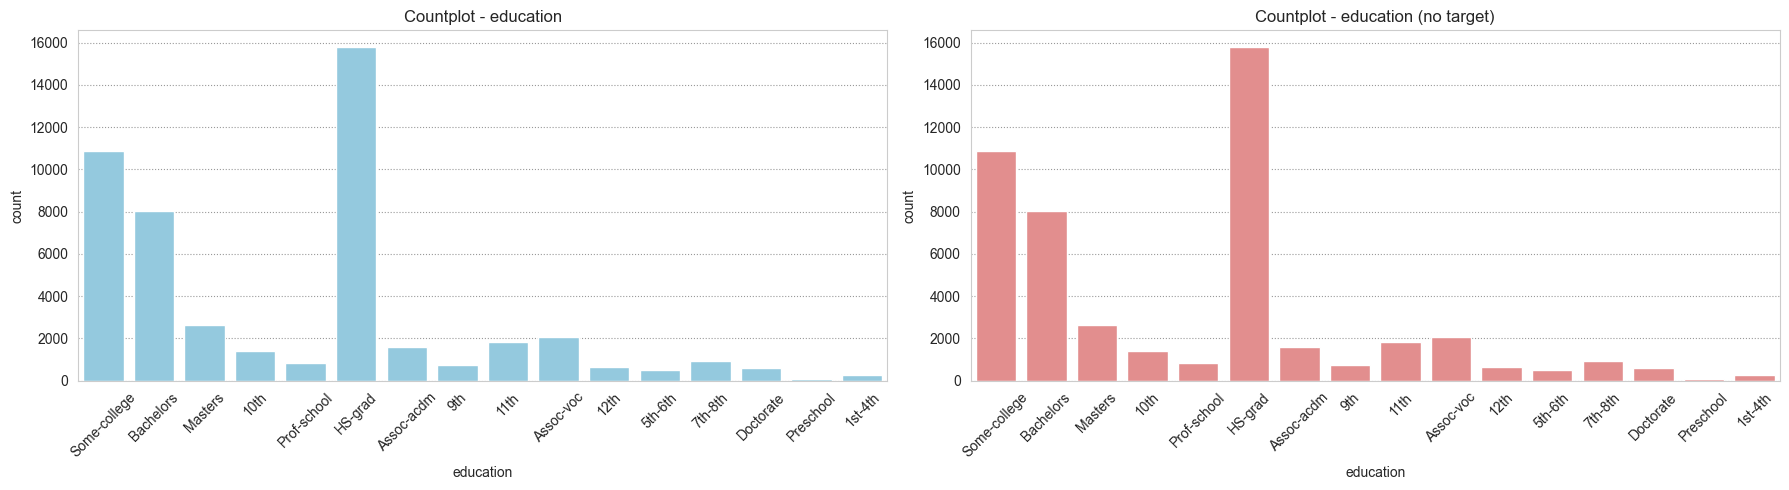

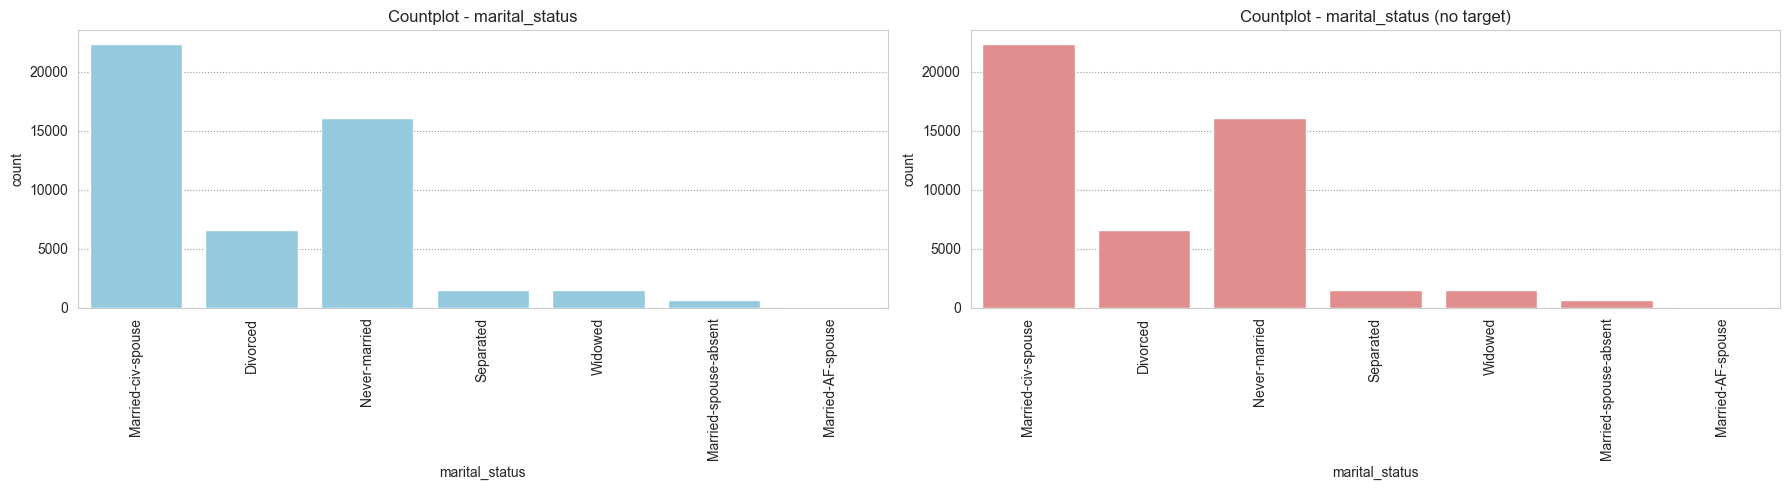

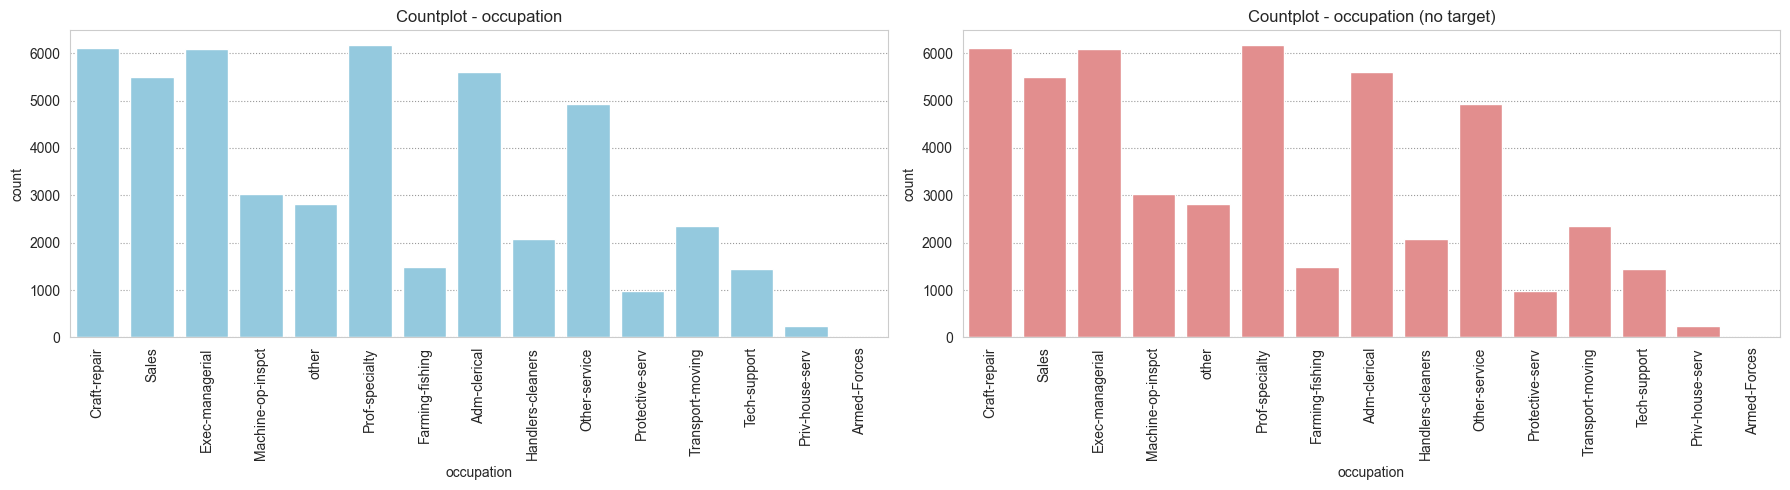

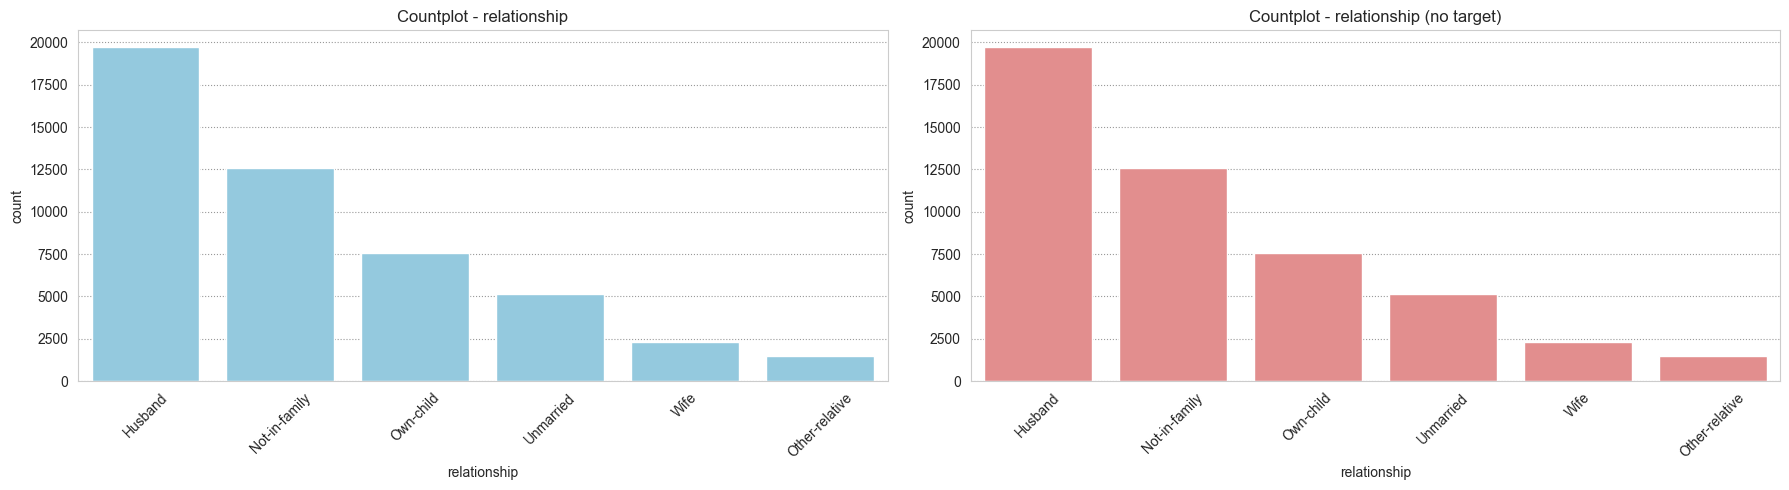

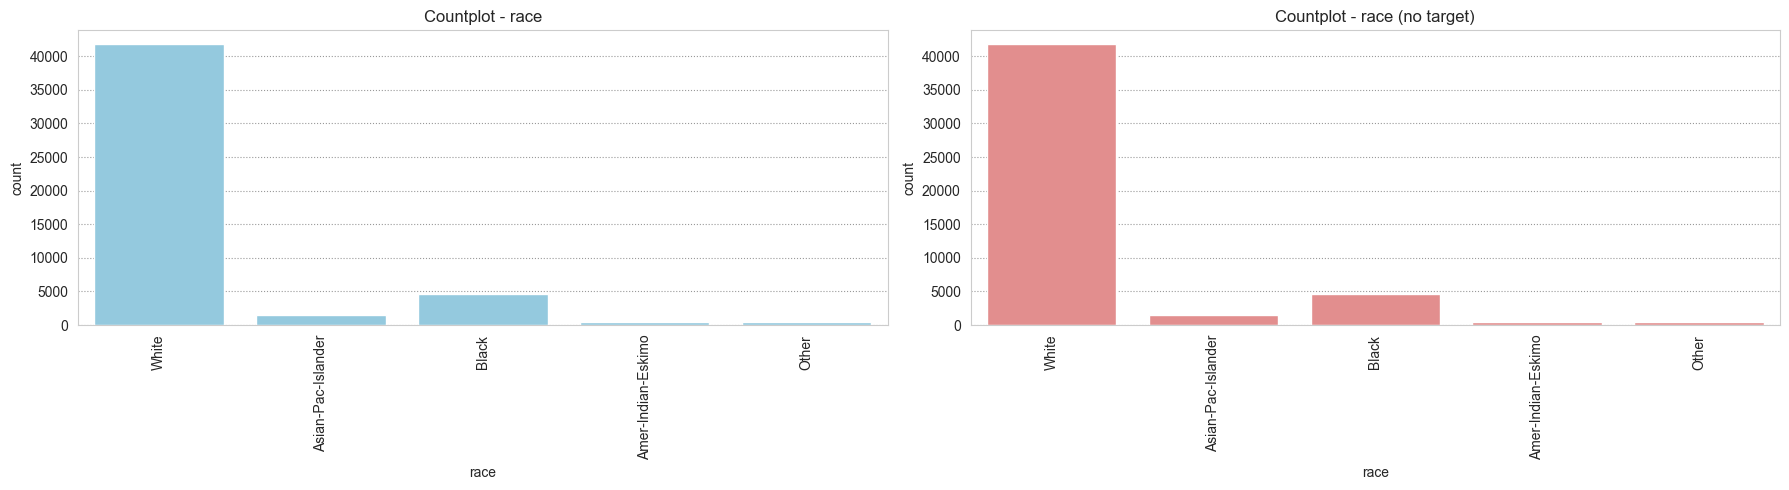

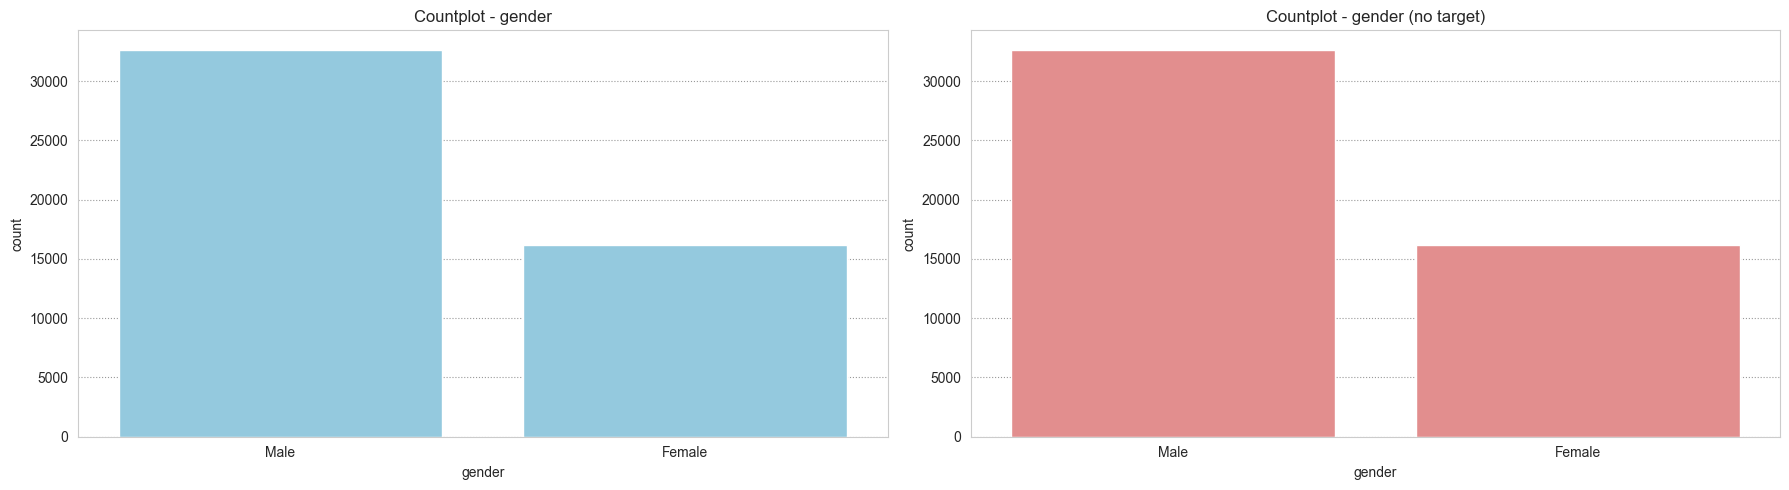

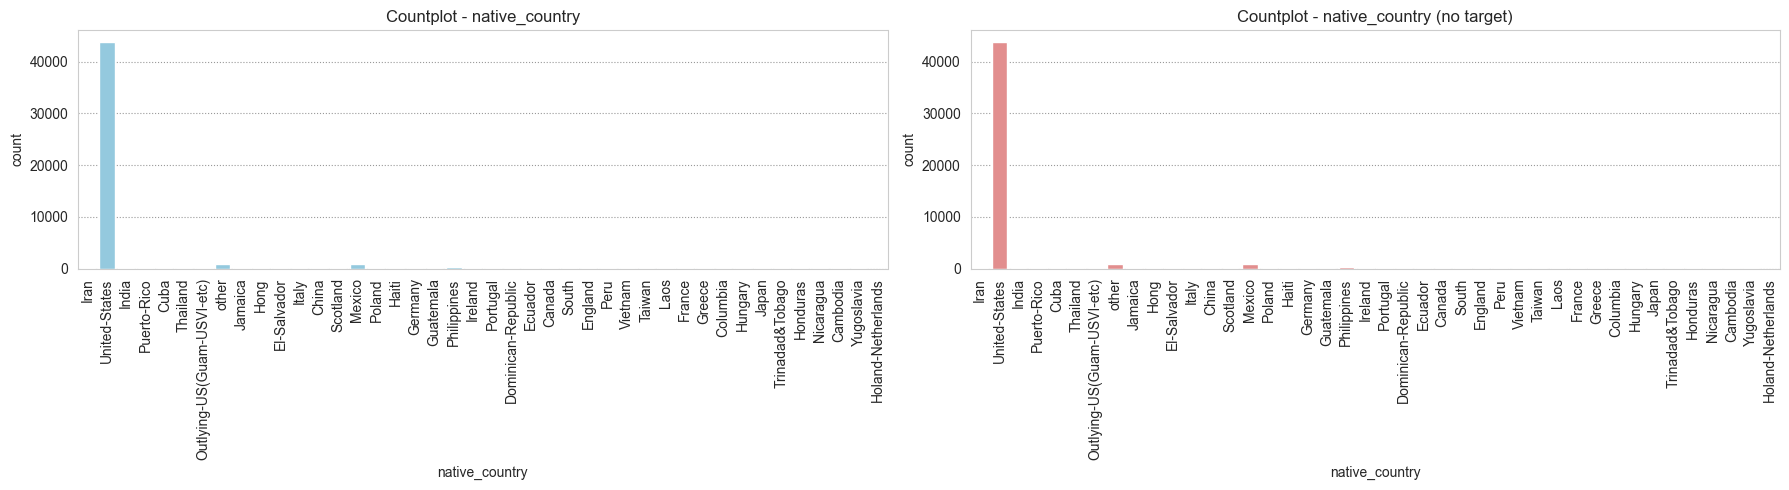

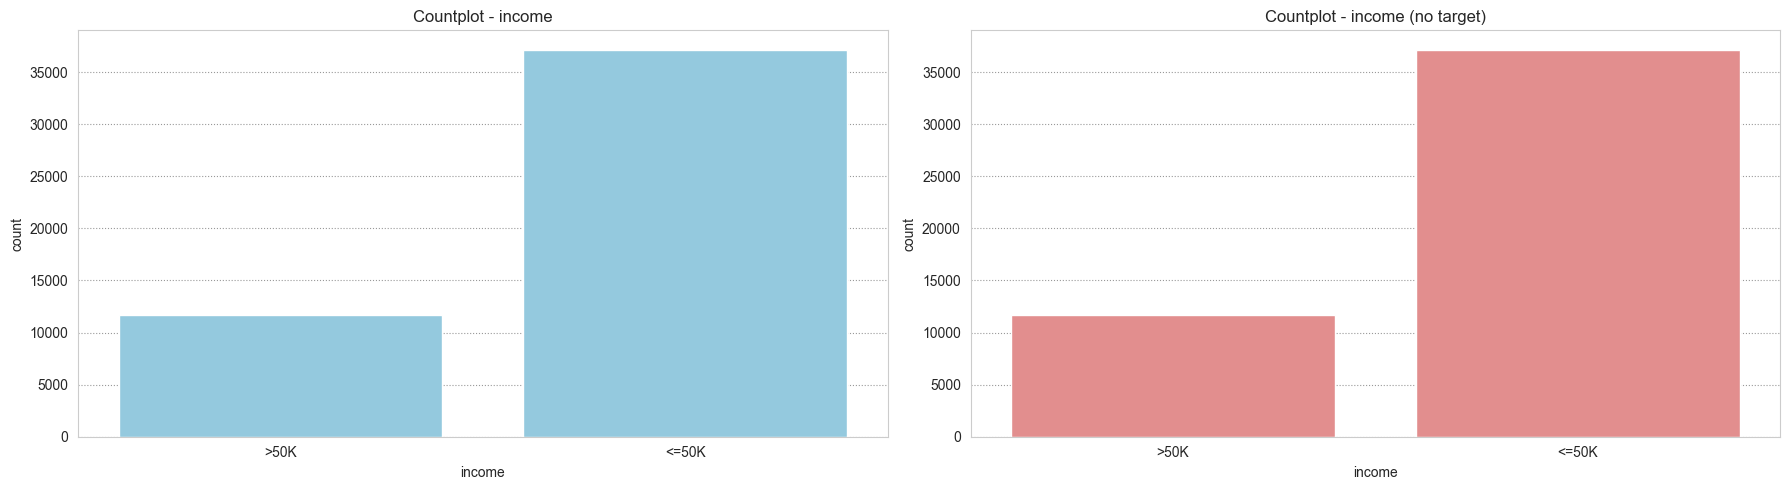

In [183]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)
# Drawer.plot_categorical_plotly(df)

# Статистическая обработка данных

## стат.обработка непрерывных данных

In [184]:
df.select_dtypes(include='number').columns


Index(['age', 'fnlwgt', 'educational_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

In [185]:
StatCriteria().mannwhitneyu(df, 'income', 'age')
StatCriteria().mannwhitneyu(df, 'income', 'fnlwgt')
StatCriteria().mannwhitneyu(df, 'income', 'educational_num')
StatCriteria().mannwhitneyu(df, 'income', 'capital_gain')
StatCriteria().mannwhitneyu(df, 'income', 'capital_loss')
StatCriteria().mannwhitneyu(df, 'income', 'hours_per_week')

Mann-Whitney U test
U_statistic = 296257069.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 215371681.500
Распределения двух выборок равны (p-value = 0.190).
Mann-Whitney U test
U_statistic = 311010711.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 256072614.500
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 231968419.000
Распределения двух выборок не равны (p-value = 0.000).
Mann-Whitney U test
U_statistic = 291741763.000
Распределения двух выборок не равны (p-value = 0.000).


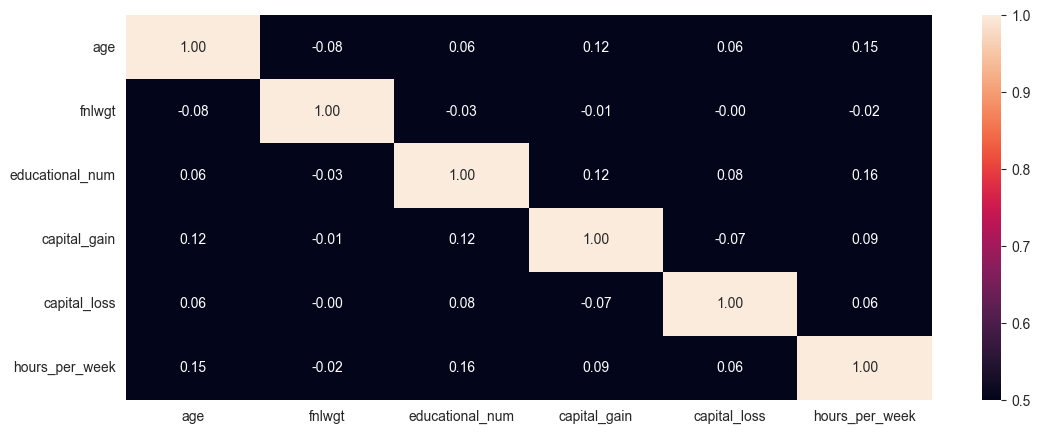

In [186]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

## стат.обработка категориальных данных

Chi-square test
chisq_statistic = 3906.108, dof = 120.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 2140.492, dof = 48.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 62533.418, dof = 112.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 2481.008, dof = 40.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 664.102, dof = 32.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 1125.257, dof = 8.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 716.252, dof = 328.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 1610.752, dof = 8.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 3906.108, dof = 120.000
Две переменные зависимы (p-value = 0.000).
Chi-square test
chisq_statistic = 2423.187, dof = 90.000
Две переменные зависимы (p-value = 0.000).

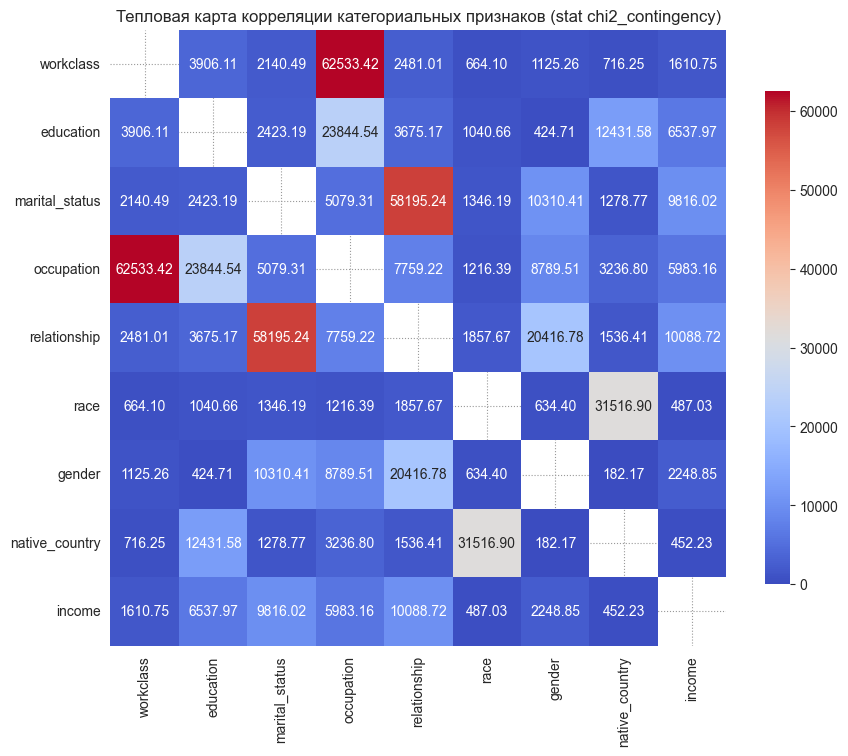

In [187]:
categorical_features = df.select_dtypes(include='object').columns.tolist()

corr_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for i in categorical_features:
    for j in categorical_features:
        if i == j:
            stat = 0
        else:
            stat, p_value, _, _ = StatCriteria().chi2_contingency(df, i, j)
            corr_matrix.loc[i, j] = stat if stat is not None else 0
        
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmin=0)
plt.title('Тепловая карта корреляции категориальных признаков (stat chi2_contingency)')
plt.show()

# Подготовка данных для обучения

In [188]:
# кодируем данные общего датасета
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['native_country'] = df['native_country'].apply(lambda x: 1 if 'United-States' else 0)
df['race'] = df['race'].apply(lambda x: 1 if 'white' else 0)

In [189]:
# проверяем является ли education и educational_num одним и тем же
df.groupby(['education', 'educational_num'])['educational_num'].mean()

education     educational_num
10th          6                   6.0
11th          7                   7.0
12th          8                   8.0
1st-4th       2                   2.0
5th-6th       3                   3.0
7th-8th       4                   4.0
9th           5                   5.0
Assoc-acdm    12                 12.0
Assoc-voc     11                 11.0
Bachelors     13                 13.0
Doctorate     16                 16.0
HS-grad       9                   9.0
Masters       14                 14.0
Preschool     1                   1.0
Prof-school   15                 15.0
Some-college  10                 10.0
Name: educational_num, dtype: float64

In [190]:
df.head(5)

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,47,Self-emp-not-inc,190072,Some-college,10,Married-civ-spouse,Craft-repair,Husband,1,1,0,0,40,1,1
1,37,Self-emp-inc,30529,Bachelors,13,Married-civ-spouse,Sales,Husband,1,1,0,2415,50,1,1
2,45,Federal-gov,179638,Masters,14,Divorced,Exec-managerial,Not-in-family,1,1,0,0,40,1,1
3,61,Private,129246,10th,6,Married-civ-spouse,Craft-repair,Husband,1,1,0,0,48,1,0
4,30,Private,196396,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,1,1,0,0,40,1,0


In [191]:
# разделяем данные
target = ['income']
# exclude_features = ['income', 'education']  ## education - дублирующая колонка
# exclude_features = ['income', 'education','fnlwgt'] ## по критерию манна-уитни income и fnlwgt
# exclude_features = ['income', 'education','fnlwgt', 'workclass', 'marital_status']  ## из корреляционной карты категориальных признаков
exclude_features = ['income', 'education', 'fnlwgt', 'workclass', 'marital_status', 'race','native_country']  ## добавлено по результатам L1 регуляризации: race, native_country

X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

In [192]:
# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

for column in columns_for_encoding:
  X_train[column], encoder = Encoder.targetEncoder(X_train[column], y_train)
  X_test[column] = encoder.transform(X_test[column])


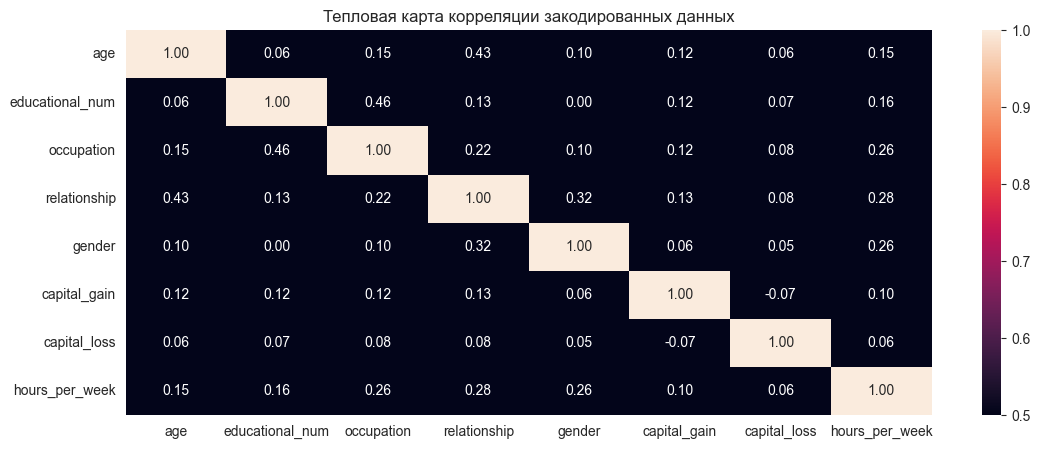

In [193]:
plt.figure(figsize=(13,5))
sns.heatmap(X_train.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.title('Тепловая карта корреляции закодированных признаков для обучения модели')
plt.show()

In [195]:
X_train, X_test, _, _ = Normalizer.standard_scaler(X_train, X_test, y_train, y_test)

# Обучаем модель

In [196]:
# Наивный байесовский классификатор
y_test, y_pred = ClassificationModel().GaussianNB(X_train, X_test, y_train, y_test)

Accuracy: 0.82
Precision: 0.80
Recall: 0.82
F1-score: 0.80


C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [197]:
# Логистическая регрессия с L1-регуляризацией
y_test, y_pred = ClassificationModel().LogisticRegression(X_train, X_test, y_train, y_test, penalty='l1', solver='liblinear', max_iter=1000, C=0.1)

Accuracy: 0.85
Precision: 0.84
Recall: 0.85
F1-score: 0.84
__________
Коэффициенты регуляризации:
age: 0.32
educational_num: 0.69
occupation: 0.45
relationship: 1.27
gender: 0.05
capital_gain: 2.39
capital_loss: 0.25
hours_per_week: 0.33


C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


признаки, которые можно исключить:
age,
fnlwgt,
capital_gain,
capital_loss,
hours_per_week

In [198]:
#SVC по умолчанию имеет следующие ядра: rbf, linear, poly, sigmoid
y_test, y_pred = ClassificationModel().SVC(X_train, X_test, y_train, y_test, kernel='rbf')

C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.86
Precision: 0.85
Recall: 0.86
F1-score: 0.85


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      9360
           1       0.73      0.44      0.55      2851

    accuracy                           0.83     12211
   macro avg       0.79      0.69      0.72     12211
weighted avg       0.82      0.83      0.81     12211

Accuracy: 0.83
Precision: 0.82
Recall: 0.83
F1-score: 0.81


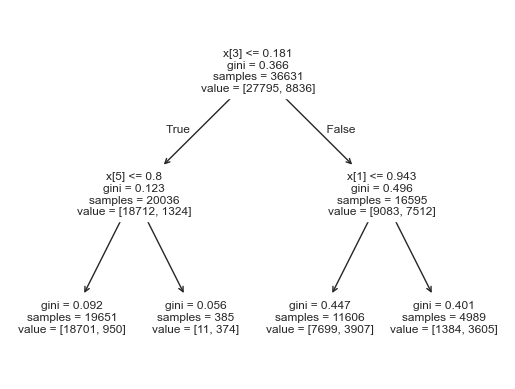

In [199]:
#Создать классификатор на основе дерева решений
y_test, y_pred = ClassificationModel().DecisionTreeClassifier(X_train, X_test, y_train, y_test, max_depth=2, criterion='gini')

In [200]:
# KNN модель из sklearn
y_test, y_pred = ClassificationModel().KNeighborsClassifier(X_train, X_test, y_train, y_test, n_neighbors=5, metric='euclidean')

C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.84
Precision: 0.83
Recall: 0.84
F1-score: 0.83


In [201]:
# самописная KNN модель
model = KNNHandMade(5, 'euclidean')
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns)

MetricCalculator.show_classification_metrics(y_test, y_pred)

Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1-score: 0.84
